# Harmonizing Remote Sensing Data: A Multimodal, Multi-Resolution Patch Extraction Pipeline

### Introduction
This notebook provides a detailed walkthrough of a fundamental data processing pipeline for **multimodal remote sensing data**. Our goal is to create **spatially consistent data samples** (patches) from different sensors (e.g., optical, thermal, SAR, DEM) that operate at **different resolutions**.

This process is a critical prerequisite for training robust machine learning models, as it ensures that all input data is spatially aligned and represents the same geographic area, even when the underlying pixel sizes differ.

### Step 0: Download and Prepare Data skipped.

In [81]:
import os
import requests
import zipfile

# --- Configuration ---
url = 'https://zenodo.org/records/15635067/files/harmonizing_multimodal_RMS.zip?download=1'
zip_filename = 'downloaded_data.zip'
# A file we expect to find after extraction, to check if data is already present
check_file = 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif' 

# --- Logic ---
if os.path.exists(check_file):
    print(f"Data file '{check_file}' already exists. Skipping download and extraction.")
else:
    print(f"Data not found. Starting download from Zenodo...")
    
    try:
        # 1. Download the data
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Check for download errors
        
        with open(zip_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Download complete. Saved to '{zip_filename}'.")

        # 2. Extract the zip file
        print("Extracting files...")
        with zipfile.ZipFile(zip_filename, 'r') as z:
            z.extractall('.') # Extract to the current directory
        print("Extraction complete.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading data: {e}")
    except zipfile.BadZipFile:
        print(f"Error: Downloaded file is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
    finally:
        # 3. Remove the zip file after extraction
        if os.path.exists(zip_filename):
            os.remove(zip_filename)
            print(f"Cleaned up and removed '{zip_filename}'.")

# --- Final Verification ---
print("\n--- Data is ready for use ---")
# Update the data_path to be the current directory
data_path = '.'

Data not found. Starting download from Zenodo...
Download complete. Saved to 'downloaded_data.zip'.
Extracting files...
Extraction complete.
Cleaned up and removed 'downloaded_data.zip'.

--- Data is ready for use ---


### Step 1: Setup and Environment

**Explanation:**
Before we begin, we need to import the necessary Python libraries. We will use:
* `rasterio` for reading and manipulating raster data (like our `.tif` files).
* `geopandas` for handling vector data (like our watershed boundary shapefile).
* `matplotlib.pyplot` for creating all of our visualizations.
* `numpy` for numerical operations.
* Other libraries like `shapely.geometry` for geometric operations.

In [ ]:
%pip install rasterio matplotlib geopandas shapely > /dev/null

import os
import re 
import rasterio
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import box, Point
from rasterio.plot import show
data_path = './data/'

# Define patch size and stride
patch_size = 224
stride = 224

### Step 2: Defining Data Inputs and Study Area

**Explanation:**
This step defines all the necessary inputs for our processing pipeline. We specify the file path to our `boundary_file`, which is a shapefile defining the watershed we are interested in. We also create a list of paths to all the multimodal raster files (`raster_files`) that we want to process. These files have already been clipped to a common rectangular extent.

In [43]:
# Load the original watershed boundary polygon
boundary_gdf_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Original_Boundary.geojson')
boundary_gdf = gpd.read_file(boundary_gdf_path)

# Load the 5km buffered watershed boundary polygon
boundary_w_buffer_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_5km_Buffered_Polygon_Boundary.geojson')
boundary_w_buffer_gdf = gpd.read_file(boundary_w_buffer_path)

# Load the bounding box of the 5km buffered area
boundary_buffer_bb_path = os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_BoundingBox_of_5km_Buffered.geojson')
boundary_buffer_bb_gdf = gpd.read_file(boundary_buffer_bb_path)

# Example list of raster file paths (update to your raster paths!)
raster_files = {
    "DEM": os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_DEM_10m_Rect.tif'),
    "SAR": os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_SAR_VV_10m_Rect.tif'),
    "Optical": os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Optical_30m_Rect.tif'),
    "Thermal": os.path.join(data_path, 'HUC12_071300090405_Pine_Lake-Middle_Salt_Creek_Landsat_Thermal_30m_Rect.tif'),
}

# Define patch size and stride
patch_size = 224
stride = 224

### Step 3: Visualizing the Study Area Boundary

**Explanation:**
To understand our area of interest, we first visualize the watershed boundary. The following code reads the shapefile, creates a 5km buffer around it to include some surrounding context, and then generates a rectangular bounding box that encompasses the buffered area. This bounding box is what defines the spatial extent for all our raster files.

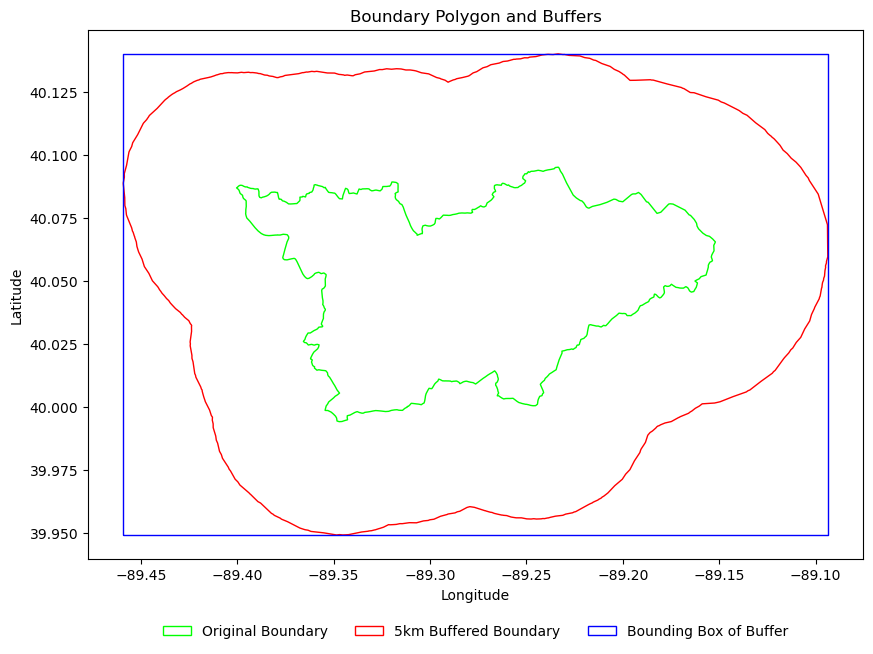

In [25]:
# ----------------------------------------------------------
# Plot all boundaries and buffers
# ----------------------------------------------------------

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original watershed boundary in lime green
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=1)

# Plot the 5km buffered boundary in red
boundary_w_buffer_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

# Plot the bounding box of the 5km buffered area in blue
boundary_buffer_bb_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

# ----------------------------------------------------------
# Create a custom legend
# ----------------------------------------------------------

# Create patches for each boundary/buffer for the legend
boundary_patch = mpatches.Patch(facecolor='none', edgecolor='lime', linewidth=1, label='Original Boundary')
buffer_patch = mpatches.Patch(facecolor='none', edgecolor='red', linewidth=1, label='5km Buffered Boundary')
bb_patch = mpatches.Patch(facecolor='none', edgecolor='blue', linewidth=1, label='Bounding Box of Buffer')

# Add the custom legend outside the plot at the bottom center
ax.legend(handles=[boundary_patch, buffer_patch, bb_patch],
          loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

# ----------------------------------------------------------
# Finalize the plot
# ----------------------------------------------------------

# Set title and axis labels
ax.set_title("Boundary Polygon and Buffers")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Display the plot
plt.show()


### Step 4: Generating and Filtering Patch Centers

**Explanation:**
Now we need to determine where to extract our data patches from. This is a two-step process:
1.  **Generate Centers:** We create a grid of evenly spaced points across the entire raster. Each point is a potential center for a data patch.
2.  **Filter Centers:** We are only interested in the watershed itself. We use a spatial query to keep only the points that fall **within our original watershed boundary**.

The code below defines the functions to perform these actions and then visualizes the results, showing all potential centers in blue and the valid, filtered centers in red.

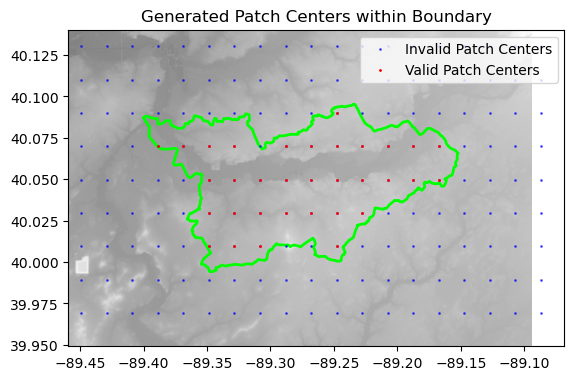

In [26]:
# Function to generate patch center points
# ----------------------------------------------
def generate_patch_centers(raster_path, patch_size, stride):
    """
    Generate patch center points (lon, lat) from a raster file.
    
    Parameters:
        raster_path (str): Path to the raster file
        patch_size (int): Size of the patch in pixels
        stride (int): Stride for window movement

    Returns:
        GeoDataFrame: Patch center points in EPSG:4326
    """
    patch_coords = []
    with rasterio.open(raster_path) as ds:
        height, width = ds.height, ds.width
        for r in range(0, height, stride):
            for c in range(0, width, stride):
                center_r = r + patch_size // 2
                center_c = c + patch_size // 2
                lon, lat = ds.xy(center_r, center_c)  # Convert pixel center to lon/lat
                patch_coords.append((lon, lat))
    
    # Create GeoDataFrame of patch center points
    patch_gdf = gpd.GeoDataFrame({'geometry': [Point(lon, lat) for lon, lat in patch_coords]}, crs='EPSG:4326')
    return patch_gdf

# Generate patch centers from raster
patch_centers_gdf = generate_patch_centers(raster_files["DEM"], patch_size, stride)

# Important: Make sure both are in the same CRS before spatial operation!
# Here we assume boundary_gdf is already in EPSG:4326 (same as patch_centers_gdf)
valid_centers_gdf = patch_centers_gdf[patch_centers_gdf.within(boundary_gdf.unary_union)]

# Plot boundary
base = boundary_gdf.plot(facecolor='none', edgecolor='lime', linewidth=2)

# Plot raster as a grayscale background
with rasterio.open(raster_files["DEM"]) as ds:
    # Optional: Reproject raster if needed to match boundary CRS (not done here)
    show(ds, ax=base, cmap='gray', alpha=0.5)

# Plot all patch centers in blue
patch_centers_gdf.plot(ax=base, color='blue', markersize=1, alpha=0.6, label='Invalid Patch Centers')

# Plot valid patch centers in red
valid_centers_gdf.plot(ax=base, color='red', markersize=1, alpha=1, label='Valid Patch Centers')

plt.title("Generated Patch Centers within Boundary")
plt.legend(loc='upper right')
plt.show()

### Step 5: Understanding Real-World Patch Footprints

**Explanation:**
This is a critical concept in our pipeline. While our patches have the same *pixel* dimensions (e.g., 224x224), their *real-world* size (footprint) depends on the raster's resolution. A patch from a 10m resolution raster covers less ground than a patch from a 30m resolution raster.

The following code visualizes this difference. It takes a single center point and shows the real-world area covered by a 224x224 patch for both a 10m and a 30m resolution raster, demonstrating how they are aligned by their common center point.

/tmp/ipykernel_158/3026215117.py:71: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


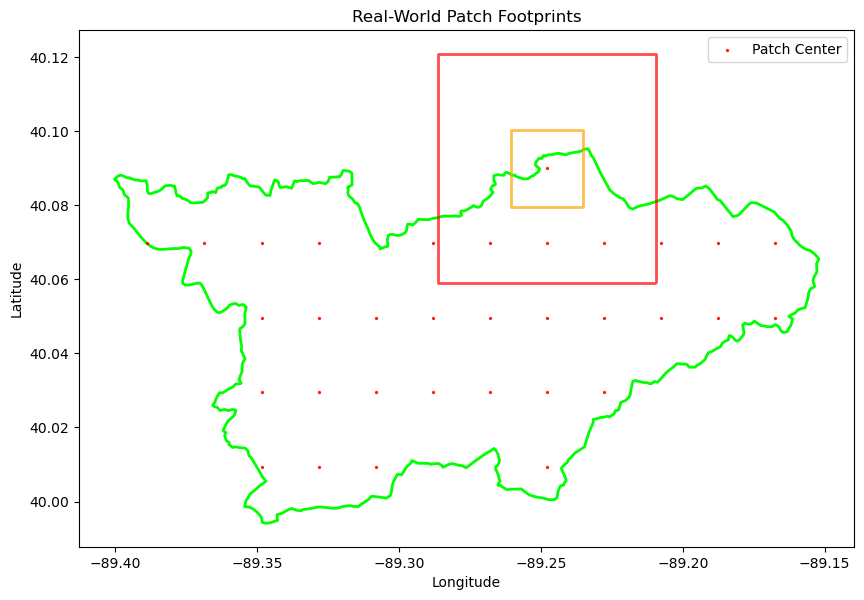

In [38]:
def extract_resolution_from_filename(filename):
    """
    Extracts the resolution in meters from the raster filename.
    Example filename: DEM_10m_Rect.tif -> returns 10
    """
    match = re.search(r'_(\d+)(m)_', filename)
    if match:
        return int(match.group(1))
    return None  # Return None if no resolution found


def visualize_real_world_patch_footprints(raster_paths, patch_centers_gdf, patch_size):
    """
    Visualizes real-world footprints of the first patch (patch 0) for multiple rasters.

    Parameters:
        raster_paths (list): List of raster file paths
        patch_centers_gdf (GeoDataFrame): GeoDataFrame with patch center points in EPSG:4326
        patch_size (int): Patch size in pixels
    """
    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the watershed boundary (assuming boundary_gdf is already defined)
    boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2, label='Boundary')

    # Loop through each raster file
    for raster_path in raster_paths:
        # Extract the resolution from the filename (e.g., 10m, 30m)
        resolution = extract_resolution_from_filename(os.path.basename(raster_path)) or 10  # Default to 10m if not found

        # Use the first valid patch center point
        center_point = patch_centers_gdf.geometry.iloc[0]
        lon, lat = center_point.x, center_point.y

        # Convert the center point to UTM coordinates for accurate real-world (meter) sizing
        transformer_to_utm = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
        utm_x, utm_y = transformer_to_utm.transform(lon, lat)

        # Calculate half the size of the patch in meters
        patch_half_size_m = (patch_size * resolution) / 2

        # Calculate min and max UTM coordinates for the patch footprint
        min_x, max_x = utm_x - patch_half_size_m, utm_x + patch_half_size_m
        min_y, max_y = utm_y - patch_half_size_m, utm_y + patch_half_size_m

        # Convert back to geographic coordinates (lon/lat) for plotting
        transformer_to_latlon = Transformer.from_crs("EPSG:32616", "EPSG:4326", always_xy=True)
        min_lon, min_lat = transformer_to_latlon.transform(min_x, min_y)
        max_lon, max_lat = transformer_to_latlon.transform(max_x, max_y)

        # Create a rectangular polygon (footprint of the patch) in EPSG:4326
        patch_box = box(min_lon, min_lat, max_lon, max_lat)
        patch_gdf = gpd.GeoDataFrame({'geometry': [patch_box]}, crs='EPSG:4326')

        # Choose color based on resolution
        color = 'cyan' if resolution == 5 else \
                'orange' if resolution == 10 else \
                'red' if resolution == 30 else 'purple'

        # Plot the patch footprint
        patch_gdf.plot(ax=ax, facecolor='none', edgecolor=color, linewidth=2, alpha=0.7, label=f'{resolution}m Patch')

    # Plot patch centers for reference
    patch_centers_gdf.plot(ax=ax, color='red', markersize=2, alpha=0.8, label='Patch Center')

    # Final plot styling
    ax.set_title("Real-World Patch Footprints")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    # plt.axis('equal')  # Keep equal aspect ratio for spatial accuracy
    plt.show()

visualize_real_world_patch_footprints([raster_files["DEM"], raster_files["Optical"]], valid_centers_gdf, patch_size=patch_size)

### Step 6: Visualizing the Final Patch Grid

**Explanation:**
The final step in a full pipeline would be to use the valid center points to extract the actual data patches from each raster file. The code below demonstrates what this final output would look like. It visualizes the grid of all the valid 224x224 patches overlaid on top of our reference raster. This confirms our patches are correctly placed within the study area and ready for use in a machine learning model.

In [35]:
def visualize_patch_grid_on_raster(raster_path, boundary_gdf, patch_centers_gdf, patch_size, stride):
    """
    Visualizes patch grid footprints on top of the raster and boundary polygon.
    
    Parameters:
        raster_path (str): Path to the raster file
        boundary_gdf (GeoDataFrame): Boundary polygon in EPSG:4326
        patch_centers_gdf (GeoDataFrame): Patch center points in EPSG:4326
        patch_size (int): Patch size in pixels
        stride (int): Stride for window movement
    """
    # Reproject raster to EPSG:4326 to match boundary and patch centers
    with rasterio.open(raster_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': 'EPSG:4326',
            'transform': transform,
            'width': width,
            'height': height
        })

        reprojected_raster = np.empty((src.count, height, width), dtype=src.dtypes[0])
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=reprojected_raster[i - 1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:4326',
                resampling=Resampling.nearest
            )

    # Compute raster extent for plotting
    min_lon, max_lat = transform * (0, 0)
    max_lon, min_lat = transform * (width, height)
    extent = (min_lon, max_lon, min_lat, max_lat)

    # Plot raster
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(reprojected_raster[0], cmap='gray', extent=extent, alpha=0.8)

    # Plot the watershed boundary
    boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=1)

    # Plot valid patch centers
    patch_centers_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='Patch Centers')

    # Create patch grid footprints (yellow rectangles)
    for center_point in patch_centers_gdf.geometry:
        lon, lat = center_point.x, center_point.y
        # Calculate footprint in lon/lat
        half_pixel_deg_x = (patch_size * src.res[0]) / 2
        half_pixel_deg_y = (patch_size * src.res[1]) / 2
        min_x, max_x = lon - half_pixel_deg_x, lon + half_pixel_deg_x
        min_y, max_y = lat - half_pixel_deg_y, lat + half_pixel_deg_y
        rect = box(min_x, min_y, max_x, max_y)
        patch_gdf = gpd.GeoDataFrame({'geometry': [rect]}, crs='EPSG:4326')
        patch_gdf.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=1, alpha=0.5)

    # Final plot styling
    res = extract_resolution_from_filename(raster_path)
    ax.set_title(f"Patches at {res}m Resolution \n (Raster: {os.path.basename(raster_path)})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='lower left', frameon=True)
    ax.set_aspect('equal')
    plt.show()

visualize_patch_grid_on_raster(
    raster_path=raster_files["DEM"],
    patch_centers_gdf=valid_centers_gdf,
    boundary_gdf=boundary_gdf,
    patch_size=patch_size,
    stride=stride
)

visualize_patch_grid_on_raster(
    raster_path=raster_files["Thermal"],
    patch_centers_gdf=valid_centers_gdf,
    boundary_gdf=boundary_gdf,
    patch_size=patch_size,
    stride=stride
)

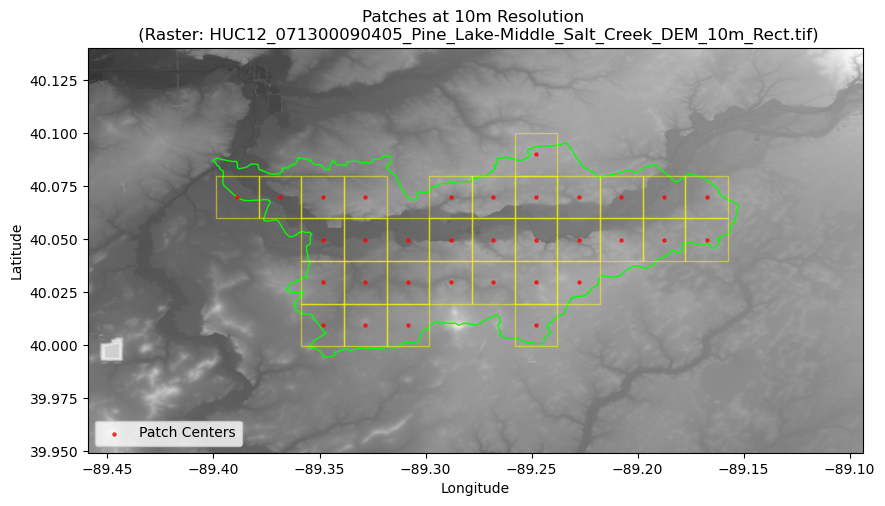

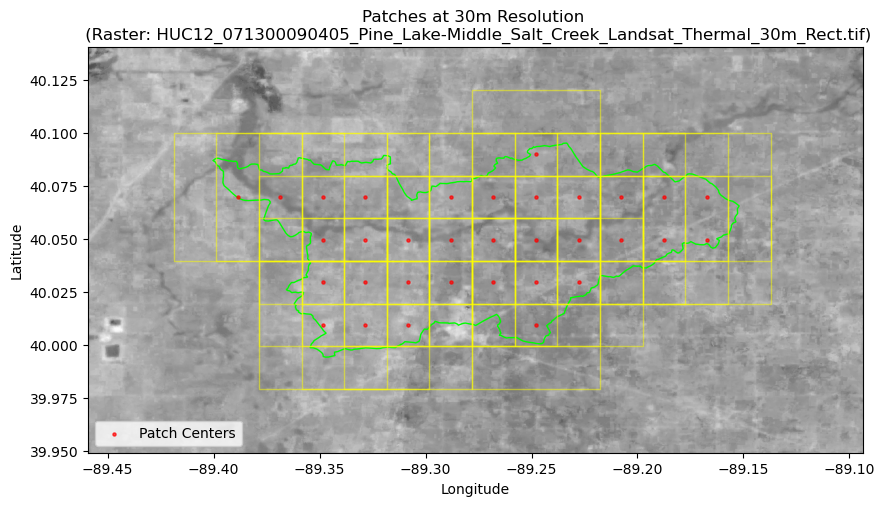

### Step 7: Extracting and Visualizing Patch Data

Now that we have our valid center points, we can proceed with the core task: extracting a data patch from each multimodal raster file for a given location. This section contains the functions to:
1.  **Extract Data by Geographic Location:** Read the raster data corresponding to a specific geographic window around a center point. It handles cases where the patch goes over the edge of the raster by adding padding.
2.  **Visualize Side-by-Side:** Plot the extracted patches from each data source to visually compare their content and real-world footprint.

We will demonstrate two types of visualizations:
* **Individual Scale:** Each patch is shown in its own geographic extent. This highlights how a patch from a 10m raster covers less area than one from a 30m raster.
* **Same Scale:** All patches are plotted on the same, larger geographic extent. This clearly shows the difference in resolution and coverage.

In [73]:
def extract_patch_data_and_extent(raster_path, center_point, patch_size, pad_value=0):
    with rasterio.open(raster_path) as ds:
        transform = ds.transform
        width, height = ds.width, ds.height

        # Convert center point to pixel coordinates
        target_r, target_c = ds.index(center_point.x, center_point.y)

        # Calculate window
        window_r = target_r - patch_size // 2
        window_c = target_c - patch_size // 2
        window = rasterio.windows.Window(window_c, window_r, patch_size, patch_size)

        # Compute actual intersection window
        full_window = rasterio.windows.Window(0, 0, width, height)
        actual_window = window.intersection(full_window)

        # Read data
        data = ds.read(window=actual_window)

        # Pad data if needed
        padded_patch = np.full((ds.count, patch_size, patch_size), pad_value, dtype=ds.dtypes[0])
        row_off = max(0, -window_r)
        col_off = max(0, -window_c)
        padded_patch[:, row_off:row_off + actual_window.height, col_off:col_off + actual_window.width] = data

        # Calculate real-world extent (lon/lat)
        min_lon, max_lat = transform * (window_c, window_r)
        max_lon, min_lat = transform * (window_c + patch_size, window_r + patch_size)
        extent = (min_lon, max_lon, min_lat, max_lat)

        return padded_patch, extent

def visualize_real_world_patch_data(raster_dict, patch_centers_gdf, boundary_gdf, patch_size, pad_value=0):
    """Visualizes the data of the first patch from each raster, using a dictionary for inputs."""
    num_rasters = len(raster_dict)
    fig, axes = plt.subplots(1, num_rasters, figsize=(6 * num_rasters, 7), constrained_layout=True)

    if num_rasters == 1:
        axes = [axes]

    # Iterate through the dictionary's items (label, path)
    for ax, (label, raster_path) in zip(axes, raster_dict.items()):
        resolution = extract_resolution_from_filename(raster_path)
        if resolution is None:
            resolution = 10 # Default resolution

        # Use the first valid center point for demonstration
        center_point = patch_centers_gdf.geometry.iloc[0]
        lon, lat = center_point.x, center_point.y

        # Extract patch data and its geographic extent
        patch_data, extent = extract_patch_data_and_extent(
            raster_path, center_point, patch_size, pad_value
        )

        # Plot the patch data using its real-world extent
        if patch_data.shape[0] == 1: # Grayscale
            ax.imshow(patch_data[0], cmap='viridis', extent=extent, origin='upper', alpha=0.8)
        else: # Assumes RGB for multi-band
            ax.imshow(np.transpose(patch_data[:3], (1, 2, 0)), extent=extent, origin='upper', alpha=0.8)

        # Overlay the boundary for context
        boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=2, alpha=1.0)

        # Plot the center point
        ax.scatter(lon, lat, color='red', s=30, zorder=10, label='Patch Center')
        
        # Use the label from the dictionary for a cleaner title
        ax.set_title(f"Modality: {label}\nResolution: {resolution}m")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.tick_params(axis='x', rotation=45)
        ax.legend()

    plt.suptitle("Real-World Spatial Extent of Patch 0 Data", fontsize=18)
    plt.show()


def extract_patch_data(raster_path, center_point, patch_size, pad_value=0):
    """Extracts patch data around a geographic center point."""
    with rasterio.open(raster_path) as ds:
        # Convert center point to pixel coordinates
        target_r, target_c = ds.index(center_point.x, center_point.y)

        # Calculate window
        window_r = target_r - patch_size // 2
        window_c = target_c - patch_size // 2
        window = rasterio.windows.Window(window_c, window_r, patch_size, patch_size)

        # Read data using boundless=True to handle edges
        patch_data = ds.read(window=window, boundless=True, fill_value=pad_value)

        return patch_data

def visualize_patch_data(raster_files_dict, patch_centers_gdf, patch_size, pad_value=0):
    """Visualizes the data of the first patch from each raster in pixel coordinates (Row/Column)."""
    num_rasters = len(raster_files_dict)
    fig, axes = plt.subplots(1, num_rasters, figsize=(6 * num_rasters, 7), constrained_layout=True)

    if num_rasters == 1:
        axes = [axes]

    for ax, (label, raster_path) in zip(axes, raster_files_dict.items()):
        resolution = extract_resolution_from_filename(raster_path)
        if resolution is None:
            resolution = 10 # Default resolution

        # Use the first valid center point for demonstration
        center_point = patch_centers_gdf.geometry.iloc[0]

        # Extract patch data
        patch_data = extract_patch_data(
            raster_path, center_point, patch_size, pad_value
        )

        # Plot the patch data using its pixel dimensions
        if patch_data.shape[0] == 1: # Grayscale
            ax.imshow(patch_data[0], cmap='viridis', origin='upper', alpha=0.8)
        else: # RGB
            ax.imshow(np.transpose(patch_data[:3], (1, 2, 0)), origin='upper', alpha=0.8)

        # Plot the center pixel
        center_pixel = patch_size // 2
        ax.scatter(center_pixel, center_pixel, color='red', s=40, marker='+', zorder=10, label='Patch Center')
        
        ax.set_title(f"{label}\nResolution: {resolution}m")
        ax.set_xlabel("Column")
        ax.set_ylabel("Row")
        ax.legend()

    plt.suptitle(f"Patch Data (Pixel Coordinates: {patch_size}x{patch_size})", fontsize=18)
    plt.show()

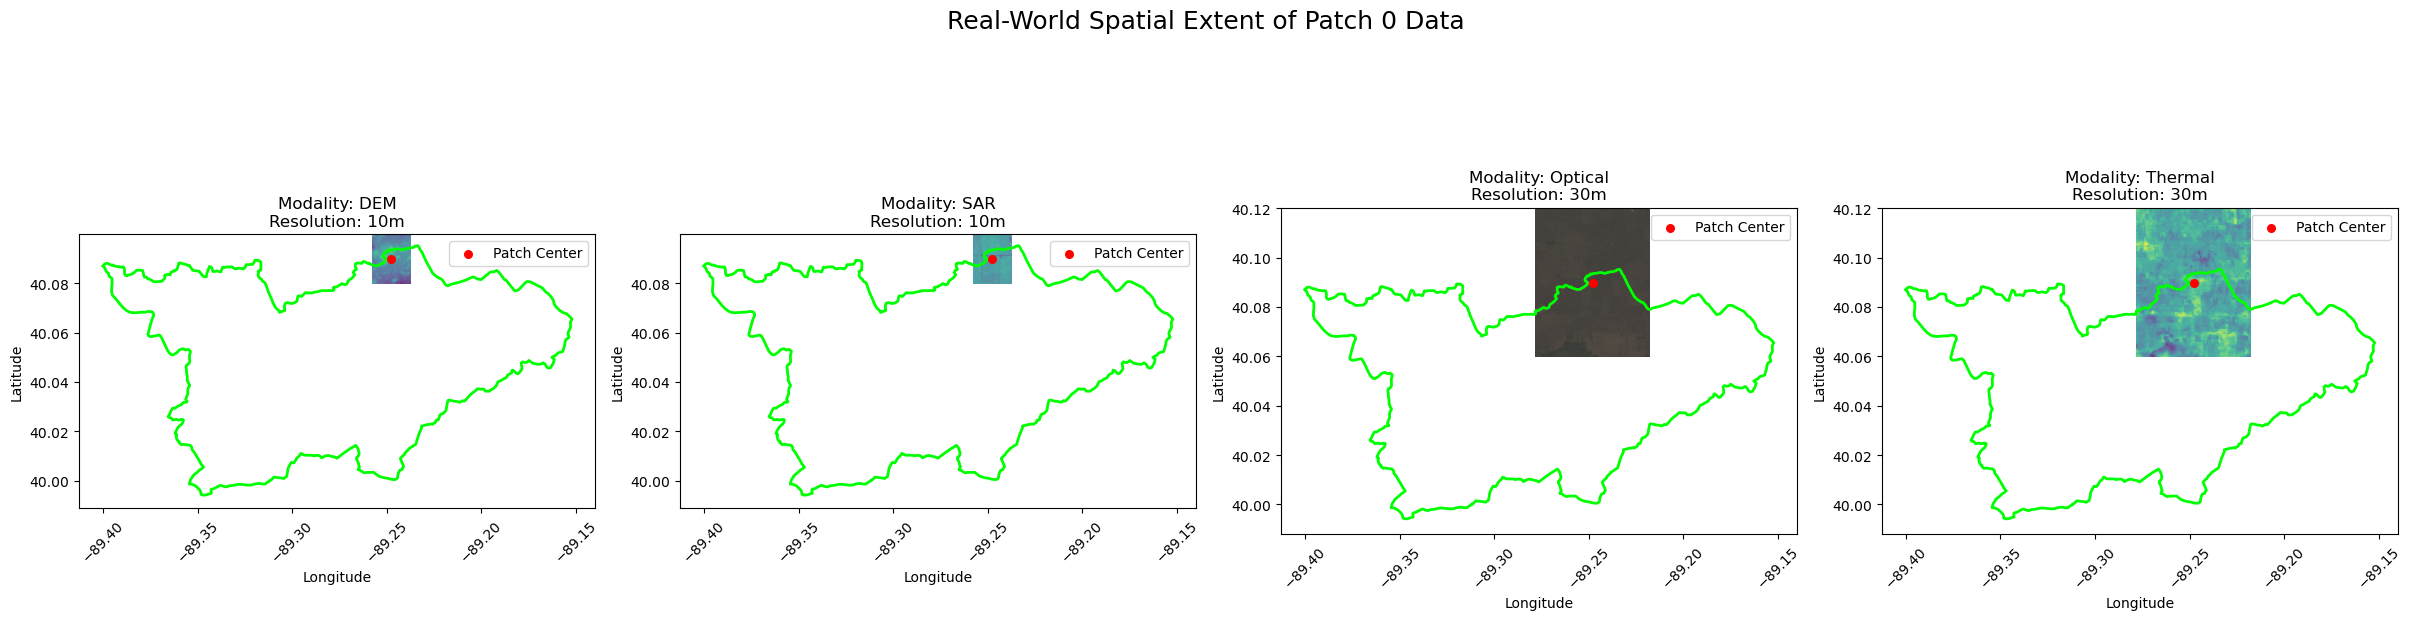

In [74]:
# Visualize patch 0 from each raster side by side
visualize_real_world_patch_data(raster_files, valid_centers_gdf, boundary_gdf, patch_size)

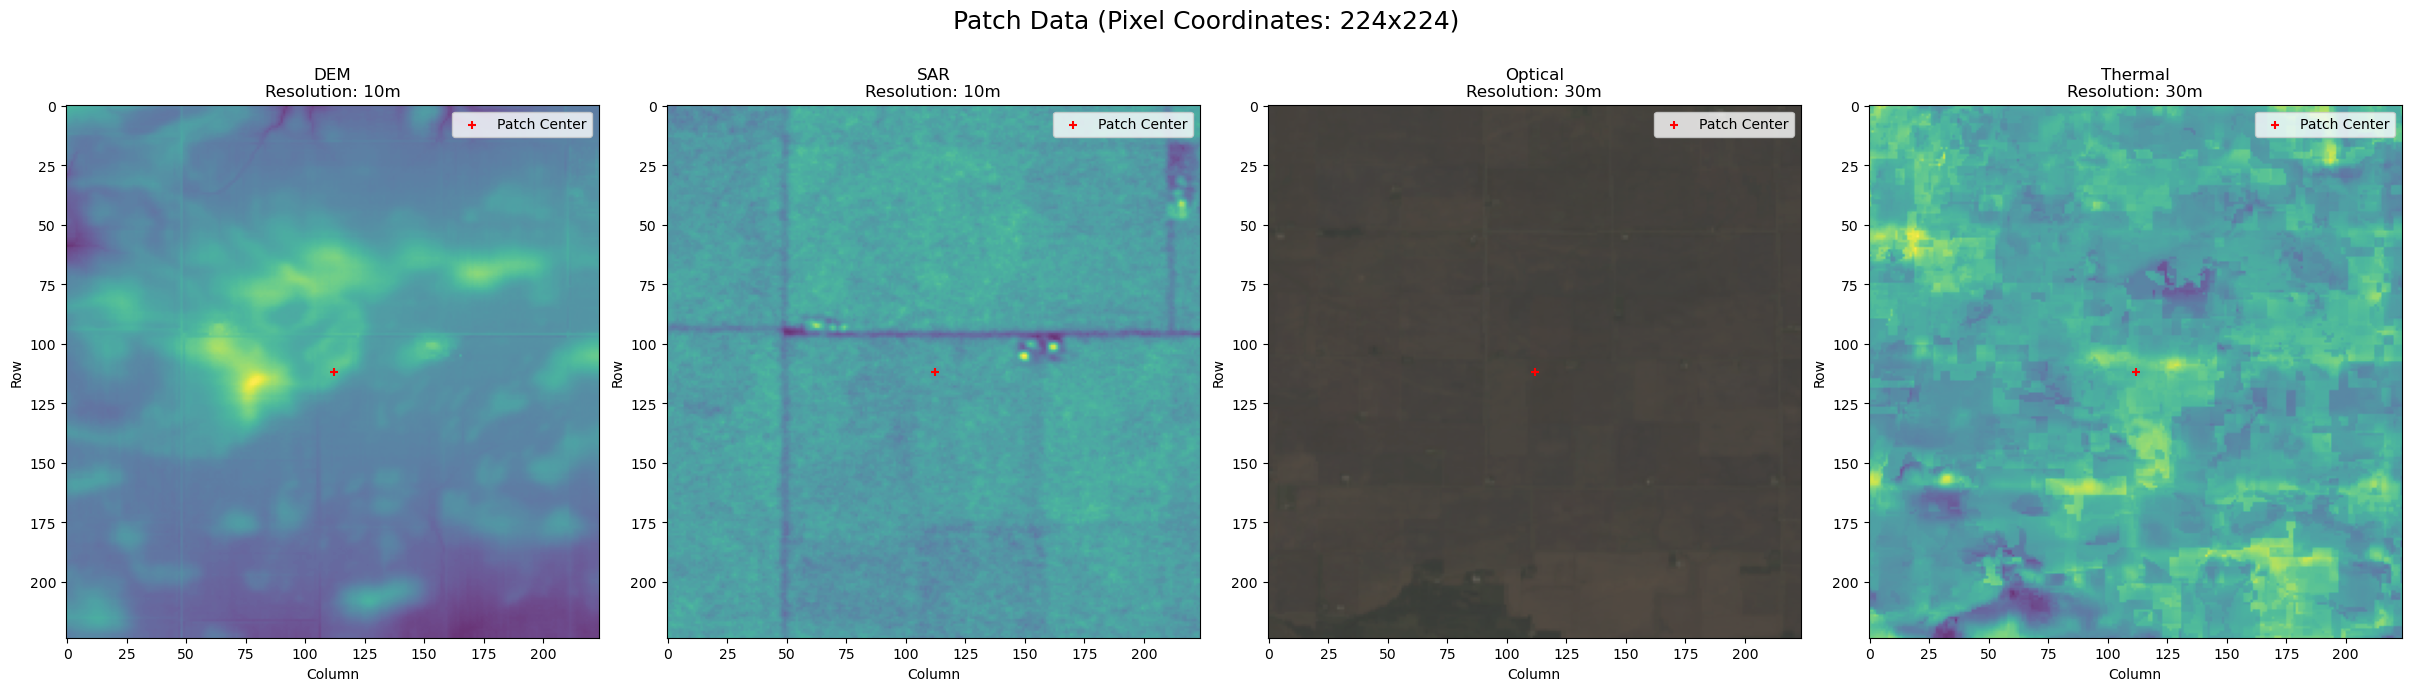

In [70]:
visualize_patch_data(raster_files, valid_centers_gdf, patch_size)

# Conclusion and Next Steps

This notebook has successfully demonstrated a complete, foundational pipeline for processing multimodal and multi-resolution remote sensing data. We have walked through each critical step:

1.  **Defining the Study Area:** We started by loading a vector boundary to establish our precise area of interest.
2.  **Generating Valid Patch Locations:** We created a systematic grid of patch center points and filtered them to ensure they were relevant to our study area, preventing unnecessary processing.
3.  **Harmonizing Multi-Resolution Data:** We tackled the core challenge of multi-resolution data by adopting a **Native Resolution Extraction** method. We visualized how patches of the same pixel dimensions (224x224) correspond to different real-world footprints.
4.  **Extracting Aligned Patches:** Finally, we extracted data patches from four different sources (DEM, SAR, Optical, and Thermal), confirming that for any given location, we can retrieve a perfectly aligned stack of multimodal data.

### Why This is Important

The process detailed here is the essential first step in preparing data for our proposed **multimodal, multitask deep learning framework**. By avoiding resampling and preserving the native resolution of each data source, we maintain the highest possible data integrity while remaining computationally efficient. The output of this pipeline is an analysis-ready dataset, where each sample provides a rich, multi-layered view of a specific geographic location.

### Next Steps

With this data preparation workflow established, the subsequent steps in the research project are:

* **Scaling Up:** Applying this process across dozens of HUC8 watersheds to build a large-scale training dataset.
* **Data Serialization:** Saving the extracted multimodal patches to an efficient storage format (e.g., HDF5 or TFRecords).
* **Model Implementation:** Building the data loaders and the deep learning model in a framework like PyTorch or TensorFlow.
* **Training and Evaluation:** Training the model to jointly predict streamline locations and flow direction, and then evaluating its performance and generalizability across different regions.

This notebook serves as the blueprint for creating the high-quality, harmonized data necessary to achieve the goal of national-scale hydrographic mapping.